In [1]:
import cassio
import os
from dotenv import load_dotenv

load_dotenv()

ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token=ASTRA_DB_APPLICATION_TOKEN,
    database_id=ASTRA_DB_ID
)

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

##Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500, chunk_overlap = 0
)



doc_split = text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
import tqdm as notebook_tqdm

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

d:\LangChain_Projects\GraphLangChain\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_groq import ChatGroq

groq_api_key = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

llm = ChatGroq(api_key=groq_api_key, model_name = "llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F11CD83670>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F11CC99AB0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
from langchain.vectorstores.cassandra import Cassandra 
astra_db = Cassandra(
    embedding=embeddings,
    table_name= "QA_mini",
    session = None,
    keyspace = None, 
)

In [7]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_db.add_documents(doc_split)

print("inserted %i headlines." % len(doc_split))
astra_index = VectorStoreIndexWrapper(vectorstore = astra_db)

inserted 88 headlines.


In [8]:
retriever = astra_db.as_retriever()
retriever.invoke("What is an Agent?")

[Document(id='3b2ce3bac86a487e9a3b370f71abf3bf', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

## LangGraph Application

In [9]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

d:\LangChain_Projects\GraphLangChain\venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
## Data Model 

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore","wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore."
    )

In [11]:
structures_llm_router = llm.with_structured_output(RouteQuery)

In [12]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structures_llm_router

print(
    question_router.invoke(
        {"question":"What is generative AI?"}
    )
)

print(question_router.invoke({"question":"WHat are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [13]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia tools

arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=200,
)

arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=200,
)

wikipedia = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [14]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [15]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve Documents

    Args:
        state (Dict) : The Current Graph State

    Returns:
        state (Dict) : New Key Added to state, documents, that contains retrieved documents
    """

    question = state["question"]

    ## Retrieval
    documents = retriever.invoke(question)

    return {"documents" : documents, "questions" : question}

In [16]:
def wiki_search(state):
    """
    wiki search based on re-phrased question

    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates documents key with appended web results
    """

    print("---WikiPedia---")

    question = state["question"]
    print(question)

    docs = wikipedia.invoke({"query":question})

    wiki_results = Document(page_content=docs)

    return {"documents": wiki_results, "questions":question}

In [18]:
### Edges 

def route_question(state):
    """
    Route Question to wiki search or RAG

    Args:
        state(dict) : The current Graph State
    Returns:
        state: Next Node to call
    """

    print("---ROUTE QUESTIONS---")
    question = state["question"]
    source = question_router.invoke({"question":question})

    if source.datasource == "wiki_search":
        print("---Route Question to Wiki Search---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---Route Question to Vector Search---")
        return "vectorstore"

In [19]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

## Define the nodes
workflow.add_node("wiki_search", wiki_search) ## Web Search
workflow.add_node("retrieve", retrieve) ## Web Search

## Build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
    },
)

workflow.add_edge(
    "retrieve", END
)

workflow.add_edge(
    "wiki_search", END
)

# compile
app = workflow.compile()

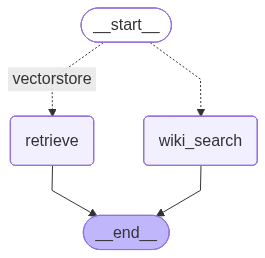

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [23]:
from pprint import pprint
#Run

inputs = {
    "question":"What is agent?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")

    pprint("\n---\n")

## Final Generation
pprint(value['documents'][0].dict()["metadata"]["description"])

---ROUTE QUESTIONS---
---Route Question to Vector Search---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results

C:\Users\rajpu\AppData\Local\Temp\ipykernel_12424\1919254234.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  pprint(value['documents'][0].dict()["metadata"]["description"])


In [27]:
from pprint import pprint
#Run

inputs = {
    "question":"Who is the father of Machine Learning?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")

    pprint("\n---\n")

## Final Generation
pprint(value['documents'])

---ROUTE QUESTIONS---
---Route Question to Wiki Search---
---WikiPedia---
Who is the father of Machine Learning?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Transformer (deep learning architecture)\nSummary: In deep learning, the transformer is a neural network architecture based on the multi-head attention mechanism, in which text is converted to nu')
